Data Loading

In [ ]:
# Cell 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Cell 2: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Cell 3: Load the Dataset
from google.colab import files
uploaded = files.upload()

Saving complete_ufc_data.csv to complete_ufc_data.csv


In [ ]:
df = pd.read_csv('complete_ufc_data.csv')
df

,event_date,event_name,weight_class,fighter1,fighter2,favourite,underdog,favourite_odds,underdog_odds,betting_outcome,...,fighter2_sig_strikes_accuracy,fighter2_sig_strikes_absorbed_pm,fighter2_sig_strikes_defended,fighter2_takedown_avg_per15m,fighter2_takedown_accuracy,fighter2_takedown_defence,fighter2_submission_avg_attempted_per15m,events_extract_ts,odds_extract_ts,fighter_extract_ts
0,2023-09-16,UFC Fight Night: Grasso vs. Shevchenko 2,Women's Flyweight,Alexa Grasso,Valentina Shevchenko,Valentina Shevchenko,Alexa Grasso,1.67,2.88,NaN,...,0.52,2.11,0.62,2.56,0.63,0.71,0.4,2023-09-21 02:02:55.178363,2023-12-28 11:40:25.898186,2023-09-20 21:50:56.958211
1,2023-09-16,UFC Fight Night: Grasso vs. Shevchenko 2,Welterweight,Jack Della Maddalena,Kevin Holland,Jack Della Maddalena,Kevin Holland,1.98,2.00,favourite,...,0.49,3.22,0.51,0.78,0.38,0.53,0.5,2023-09-21 02:02:55.178363,2023-12-28 11:40:25.898186,2023-09-20 21:50:56.958211
2,2023-09-16,UFC Fight Night: Grasso vs. Shevchenko 2,Bantamweight,Raul Rosas Jr.,Terrence Mitchell,NaN,NaN,NaN,NaN,NaN,...,0.34,8.85,0.41,3.69,0.50,0.00,0.0,2023-09-21 02:02:55.178363,NaN,2023-09-20 21:50:56.958211
3,2023-09-16,UFC Fight Night: Grasso vs. Shevchenko 2,Lightweight,Daniel Zellhuber,Christos Giagos,Daniel Zellhuber,Christos Giagos,1.40,3.10,favourite,...,0.42,2.95,0.51,2.93,0.37,0.52,0.4,2023-09-21 02:02:55.178363,2023-12-28 11:40:25.898186,2023-09-20 21:50:56.958211
4,2023-09-16,UFC Fight Night: Grasso vs. Shevchenko 2,Featherweight,Kyle Nelson,Fernando Padilla,Fernando Padilla,Kyle Nelson,1.40,3.15,underdog,...,0.38,5.81,0.53,0.00,0.00,1.00,0.0,2023-09-21 02:02:55.178363,2023-12-28 11:40:25.898186,2023-09-20 21:50:56.958211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7335,1994-03-11,UFC 2: No Way Out,Open Weight,Orlando Wiet,Robert Lucarelli,NaN,NaN,NaN,NaN,NaN,...,0.00,0.00,0.00,0.00,0.00,0.00,0.0,2023-09-21 02:02:55.178363,NaN,2023-09-20 21:50:56.958211
7336,1994-03-11,UFC 2: No Way Out,Open Weight,Frank Hamaker,Thaddeus Luster,NaN,NaN,NaN,NaN,NaN,...,0.00,0.00,0.00,0.00,0.00,0.00,0.0,2023-09-21 02:02:55.178363,NaN,2023-09-20 21:50:56.958211
7337,1994-03-11,UFC 2: No Way Out,Open Weight,Johnny Rhodes,David Levicki,NaN,NaN,NaN,NaN,NaN,...,0.00,0.00,0.00,0.00,0.00,0.00,0.0,2023-09-21 02:02:55.178363,NaN,2023-09-20 21:50:56.958211
7338,1994-03-11,UFC 2: No Way Out,Open Weight,Patrick Smith,Ray Wizard,NaN,NaN,NaN,NaN,NaN,...,0.00,0.00,0.00,0.00,0.00,0.00,0.0,2023-09-21 02:02:55.178363,NaN,2023-09-20 21:50:56.958211


Pre-Processing

In [ ]:
from datetime import datetime

# Define the reference date
reference_date = datetime(2025, 3, 14)

# Function to calculate age
def calculate_age(dob_str):
    try:
        # Convert dob_str to string if it's not already
        dob_str = str(dob_str)
        dob = datetime.strptime(dob_str, '%Y-%m-%d')
        age = (reference_date - dob).days / 365.25
        return age
    except ValueError:
        return None  # Handle cases with invalid date format

# Apply the function to the 'fighter1_dob' and 'fighter2_dob' columns
df['fighter1_age'] = df['fighter1_dob'].apply(calculate_age)
df['fighter2_age'] = df['fighter2_dob'].apply(calculate_age)

# Display the updated DataFrame (optional)
print(df[['fighter1_dob', 'fighter1_age', 'fighter2_dob', 'fighter2_age']])

     fighter1_dob  fighter1_age fighter2_dob  fighter2_age
0      1993-08-09     31.594798   1988-03-07     37.018480
1      1996-09-10     28.506502   1992-11-05     32.353183
2      2004-10-08     20.429843   1989-12-30     35.203285
3      1999-07-07     25.686516   1990-01-23     35.137577
4      1991-04-20     33.900068   1996-12-15     28.243669
...           ...           ...          ...           ...
7335          NaN           NaN          NaN           NaN
7336          NaN           NaN          NaN           NaN
7337          NaN           NaN          NaN           NaN
7338   1963-08-28     61.544148          NaN           NaN
7339          NaN           NaN   1975-12-04     49.275838

[7340 rows x 4 columns]


In [ ]:
# Count missing values (NaN) in date columns
invalid_event_dates = df['event_date'].isnull().sum()
invalid_fighter1_dobs = df['fighter1_dob'].isnull().sum()
invalid_fighter2_dobs = df['fighter2_dob'].isnull().sum()

# Print the counts
print(f"Number of rows with invalid event dates: {invalid_event_dates}")
print(f"Number of rows with invalid fighter1 DOBs: {invalid_fighter1_dobs}")
print(f"Number of rows with invalid fighter2 DOBs: {invalid_fighter2_dobs}")


Number of rows with invalid event dates: 0
Number of rows with invalid fighter1 DOBs: 93
Number of rows with invalid fighter2 DOBs: 220


In [ ]:
# Create a copy of the DataFrame to avoid modifying the original
df_cleaned = df.copy()

# Remove rows where either 'fighter1_dob' or 'fighter2_dob' is invalid (NaN)
df_cleaned.dropna(subset=['fighter1_dob', 'fighter2_dob'], inplace=True)

Calculate Fighter Stat Deltas
Deltas capture relative strengths (e.g., taller or more aggressive striker)

In [ ]:
# List of numeric fighter stats to compare
numeric_stats = ['height', 'reach', 'sig_strikes_landed_pm', 'sig_strikes_accuracy',
                 'sig_strikes_absorbed_pm', 'sig_strikes_defended', 'takedown_avg_per15m',
                 'takedown_accuracy', 'takedown_defence', 'submission_avg_attempted_per15m',
                 'curr_weight']

# Calculate stat differences
for stat in numeric_stats:
    fighter1_stat = 'fighter1_' + stat
    fighter2_stat = 'fighter2_' + stat
    diff_col = stat + '_diff'
    df_cleaned[diff_col] = df_cleaned[fighter1_stat] - df_cleaned[fighter2_stat]

# Calculate age difference
df_cleaned['age_diff'] = df_cleaned['fighter1_age'] - df_cleaned['fighter2_age']

# Print a sample of 5 rows
print(df_cleaned[['fighter1', 'fighter2', 'height_diff', 'sig_strikes_landed_pm_diff', 'age_diff']].head(5))

               fighter1              fighter2  height_diff  \
0          Alexa Grasso  Valentina Shevchenko         0.00   
1  Jack Della Maddalena         Kevin Holland       -10.16   
2        Raul Rosas Jr.     Terrence Mitchell        -2.54   
3      Daniel Zellhuber       Christos Giagos         7.62   
4           Kyle Nelson      Fernando Padilla        -5.08   

   sig_strikes_landed_pm_diff   age_diff  
0                        1.39  -5.423682  
1                        2.81  -3.846680  
2                       -0.93 -14.773443  
3                        2.28  -9.451061  
4                       -2.05   5.656400  


In [ ]:
# Check for null values in each column
null_counts = df.isnull().sum()
null_counts

,0
event_date,0
event_name,0
weight_class,0
fighter1,0
fighter2,0
favourite,3838
underdog,3838
favourite_odds,3838
underdog_odds,3838
betting_outcome,3880


In [ ]:
# Assuming df_cleaned is your DataFrame from the previous code

# Categorical columns to drop nulls from
categorical_cols = ['event_name', 'weight_class', 'fighter1', 'fighter2', 'favourite', 'underdog',
                    'betting_outcome', 'outcome', 'method', 'fighter1_stance', 'fighter2_stance']

# Numerical columns to fill nulls with mean
numerical_cols = ['fighter1_height', 'fighter1_curr_weight', 'fighter1_reach',
                  'fighter1_sig_strikes_landed_pm', 'fighter1_sig_strikes_accuracy',
                  'fighter1_sig_strikes_absorbed_pm', 'fighter1_sig_strikes_defended',
                  'fighter1_takedown_avg_per15m', 'fighter1_takedown_accuracy',
                  'fighter1_takedown_defence', 'fighter1_submission_avg_attempted_per15m',
                  'fighter2_height', 'fighter2_curr_weight', 'fighter2_reach',
                  'fighter2_sig_strikes_landed_pm', 'fighter2_sig_strikes_accuracy',
                  'fighter2_sig_strikes_absorbed_pm', 'fighter2_sig_strikes_defended',
                  'fighter2_takedown_avg_per15m', 'fighter2_takedown_accuracy',
                  'fighter2_takedown_defence', 'fighter2_submission_avg_attempted_per15m',
                  'favourite_odds', 'underdog_odds', 'round', 'fighter1_age', 'fighter2_age']


#Handling missing values in categorical columns
df_cleaned.dropna(subset=categorical_cols, inplace=True)

# Handling missing values in numerical columns
for col in numerical_cols:
    if col in df_cleaned.columns: # Check if the column exists
      df_cleaned[col].fillna(df_cleaned[col].mean(), inplace=True)

# Print some info to verify
print(df_cleaned.isnull().sum())
print(df_cleaned.info())


event_date                                    0
event_name                                    0
weight_class                                  0
fighter1                                      0
fighter2                                      0
favourite                                     0
underdog                                      0
favourite_odds                                0
underdog_odds                                 0
betting_outcome                               0
outcome                                       0
method                                        0
round                                         0
fighter1_height                               0
fighter1_curr_weight                          0
fighter1_dob                                  0
fighter1_reach                                0
fighter1_stance                               0
fighter1_sig_strikes_landed_pm                0
fighter1_sig_strikes_accuracy                 0
fighter1_sig_strikes_absorbed_pm        

<ipython-input-10-2e9c5bd29d2c>:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cleaned[col].fillna(df_cleaned[col].mean(), inplace=True)


#Encode Outcome

In [ ]:
import pandas as pd
import numpy as np

# Filter for decisive wins (fighter1 wins)
df_wins = df_cleaned[df_cleaned['outcome'] == 'fighter1'].copy()
df_wins['target'] = 1

# Create mirrored losses by copying df_wins and swapping fighter1/fighter2 data
df_losses = df_wins.copy()

# Swap fighter1 and fighter2 names
df_losses['fighter1'], df_losses['fighter2'] = df_wins['fighter2'], df_wins['fighter1']

# Swap fighter1 and fighter2 stats
fighter1_stats = ['fighter1_height', 'fighter1_curr_weight', 'fighter1_dob', 'fighter1_reach',
                  'fighter1_stance', 'fighter1_sig_strikes_landed_pm', 'fighter1_sig_strikes_accuracy',
                  'fighter1_sig_strikes_absorbed_pm', 'fighter1_sig_strikes_defended',
                  'fighter1_takedown_avg_per15m', 'fighter1_takedown_accuracy',
                  'fighter1_takedown_defence', 'fighter1_submission_avg_attempted_per15m']
fighter2_stats = ['fighter2_height', 'fighter2_curr_weight', 'fighter2_dob', 'fighter2_reach',
                  'fighter2_stance', 'fighter2_sig_strikes_landed_pm', 'fighter2_sig_strikes_accuracy',
                  'fighter2_sig_strikes_absorbed_pm', 'fighter2_sig_strikes_defended',
                  'fighter2_takedown_avg_per15m', 'fighter2_takedown_accuracy',
                  'fighter2_takedown_defence', 'fighter2_submission_avg_attempted_per15m']

for f1_stat, f2_stat in zip(fighter1_stats, fighter2_stats):
    df_losses[f1_stat], df_losses[f2_stat] = df_wins[f2_stat], df_wins[f1_stat]

# Negate existing delta columns (assumes these were calculated in Step 2)
delta_columns = ['height_diff', 'reach_diff', 'sig_strikes_landed_pm_diff', 'sig_strikes_accuracy_diff',
                 'sig_strikes_absorbed_pm_diff', 'sig_strikes_defended_diff', 'takedown_avg_per15m_diff',
                 'takedown_accuracy_diff', 'takedown_defence_diff', 'submission_avg_attempted_per15m_diff']

# Check which delta columns exist in df_cleaned and negate them
for col in delta_columns:
    if col in df_losses.columns:
        df_losses[col] = -df_losses[col]

# Set target for losses
df_losses['target'] = 0

# Combine wins and losses into df_binary
df_binary = pd.concat([df_wins, df_losses], ignore_index=True)

# Verify balance
print("Target value counts in df_binary:")
print(df_binary['target'].value_counts())

# Optional: Preview to ensure swapping worked
print("\nSample of df_binary:")
print(df_binary[['fighter1', 'fighter2', 'height_diff', 'target']].head(10))

Target value counts in df_binary:
target
1    3391
0    3391
Name: count, dtype: int64

Sample of df_binary:
               fighter1              fighter2  height_diff  target
0  Jack Della Maddalena         Kevin Holland       -10.16       1
1      Daniel Zellhuber       Christos Giagos         7.62       1
2           Kyle Nelson      Fernando Padilla        -5.08       1
3         Roman Kopylov            Josh Fremd       -10.16       1
4          Tracy Cortez  Jasmine Jasudavicius        -5.08       1
5      Charlie Campbell            Alex Reyes         2.54       1
6     Josefine Knutsson           Marnic Mann         7.62       1
7       Sean Strickland       Israel Adesanya        -7.62       1
8      Alexander Volkov           Tai Tuivasa        12.70       1
9           Justin Tafa           Austen Lane       -15.24       1


# EDA

In [ ]:
# Summary Statistics
print(df_binary.describe())
print(df_binary.groupby('weight_class').describe())

       favourite_odds  underdog_odds        round  fighter1_height  \
count         6782.00        6782.00  6782.000000      6782.000000   
mean              inf            inf     2.432616       177.556187   
std               NaN            NaN     0.998207         9.250074   
min              1.06           1.88     1.000000       152.400000   
25%              1.39           2.35     2.000000       170.180000   
50%              1.56           2.76     3.000000       177.800000   
75%              1.74           3.60     3.000000       185.420000   
max               inf            inf     5.000000       210.820000   

       fighter1_curr_weight  fighter1_reach  fighter1_sig_strikes_landed_pm  \
count           6782.000000     6782.000000                     6782.000000   
mean              73.633057      182.099722                        3.759224   
std               15.950004       11.023734                        1.293623   
min               52.163080      147.320000          

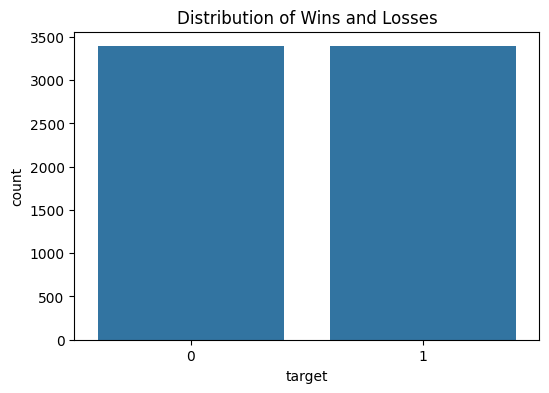

In [ ]:
# Visualize Win Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=df_binary)
plt.title('Distribution of Wins and Losses')
plt.show()

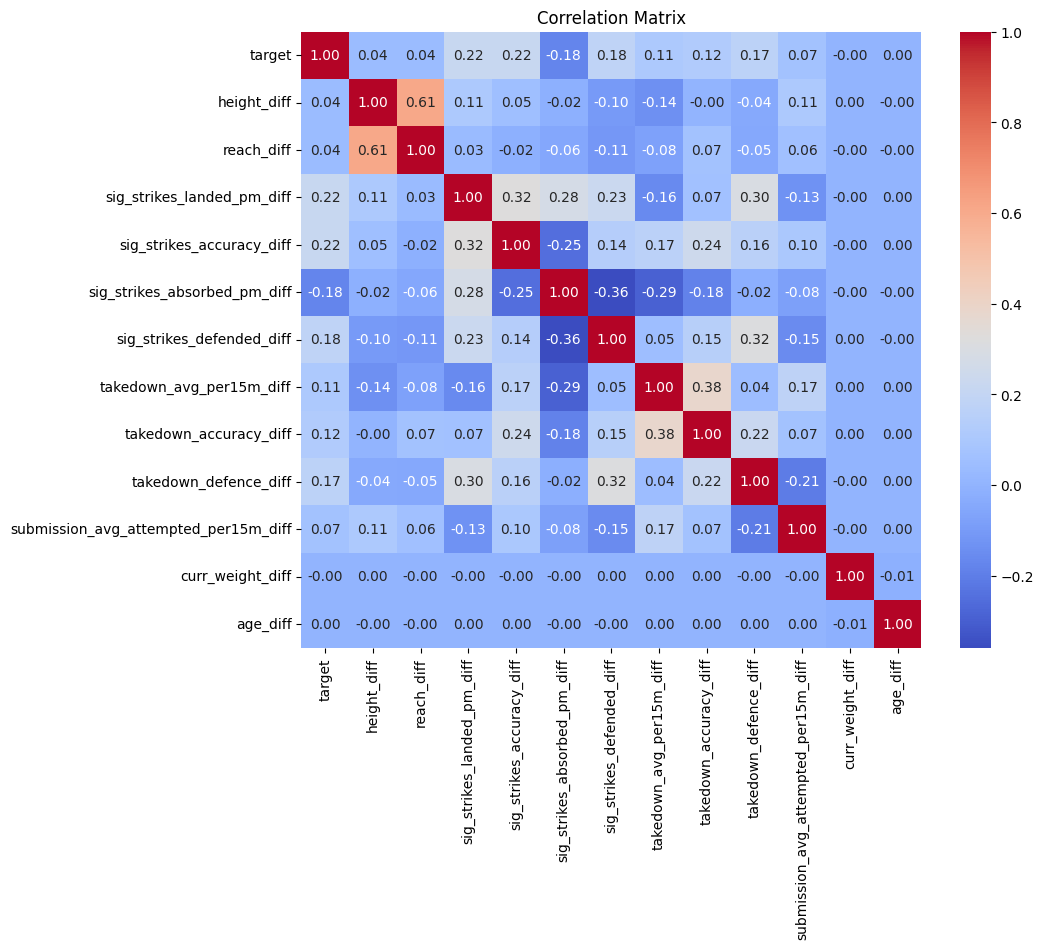

In [ ]:
# Check Correlations
correlations = df_binary[['target'] + [col for col in df_binary.columns if '_diff' in col]].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

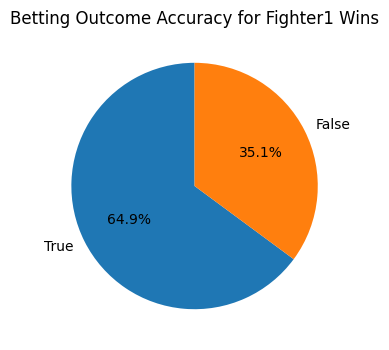

In [ ]:
# Plot Betting Odds Accuracy
fighter1_wins = df_binary[df_binary['outcome'] == 'fighter1']
accuracy = fighter1_wins['betting_outcome'] == 'favourite'
accuracy_counts = accuracy.value_counts()

plt.figure(figsize=(6, 4))
plt.pie(accuracy_counts, labels=accuracy_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Betting Outcome Accuracy for Fighter1 Wins')
plt.show()

# Model Building and Prediction

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import pickle

# Feature Selection
features = [col for col in df_binary.columns if '_diff' in col] + \
           [col for col in df_binary.columns if 'fighter1' in col and col not in ['fighter1', 'fighter1_dob','fighter1_stance']] + \
           [col for col in df_binary.columns if 'fighter2' in col and col not in ['fighter2', 'fighter2_dob','fighter2_stance']]
features = [col for col in features if col != 'age_diff']
X = df_binary[features]
y = df_binary['target']

In [ ]:
# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# Train Model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# Predictions and Feature Importance
y_pred = model.predict(X_test)
feature_importance = model.feature_importances_
print(feature_importance)

# Save the model
with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)

print("Model saved as model.pkl")

[0.0186976  0.02352322 0.06203966 0.03725447 0.04822153 0.031686
 0.03376193 0.02937419 0.03642536 0.02873573 0.01508024 0.01570423
 0.01352863 0.01879509 0.03673224 0.02921194 0.03321493 0.02373048
 0.02831594 0.02596919 0.02855018 0.0205098  0.05006184 0.01582709
 0.01295557 0.01708896 0.03589148 0.02849338 0.03344054 0.02405189
 0.02739623 0.02478124 0.02710854 0.02003926 0.04380143]
Model saved as model.pkl


Evaluation

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate Performance Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

Accuracy: 0.6787030213706706
Precision: 0.7018633540372671
Recall: 0.6494252873563219
F1-score: 0.6746268656716418


In [ ]:
# Compare to Betting Odds Baseline
wins_subset = df_binary[df_binary['outcome'] == 'fighter1']
baseline_accuracy = accuracy_score(wins_subset['target'], wins_subset['betting_outcome'] == 'favourite')
print(f"\nBetting Odds Baseline Accuracy: {baseline_accuracy}")


Betting Odds Baseline Accuracy: 0.5


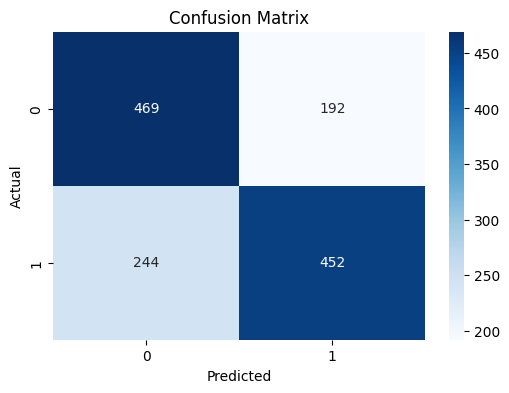

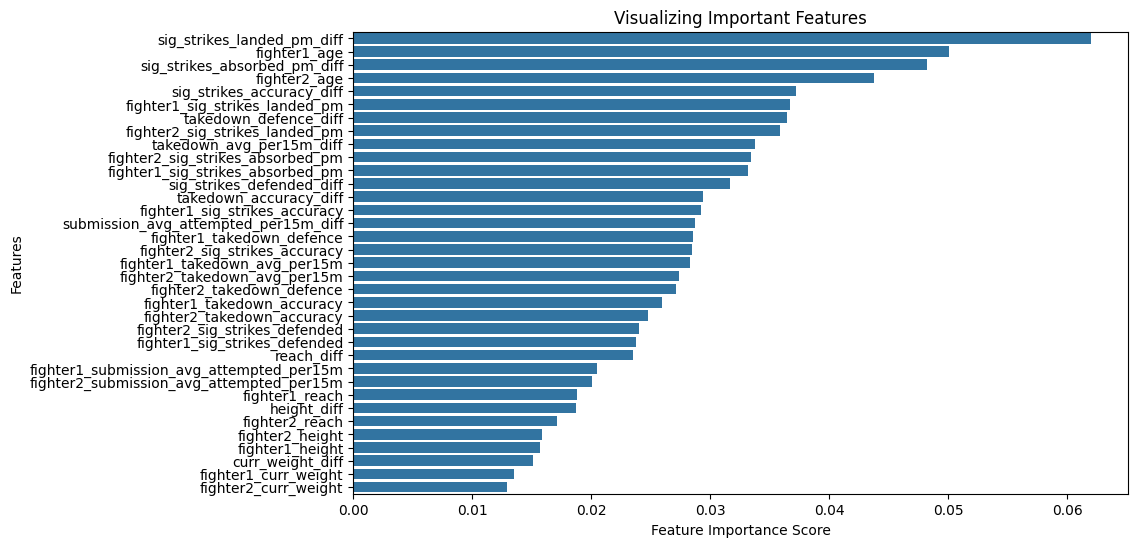

In [ ]:
# Visualize Model Performance
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

plt.figure(figsize=(10, 6))
feature_imp = pd.Series(feature_importance, index=X.columns).sort_values(ascending=False)
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

# Predictions

In [ ]:
import pickle
import pandas as pd

# Load the saved model
with open('model.pkl', 'rb') as file:
    model = pickle.load(file)

# Sample fighter data (replace with actual data)
fighter1 = "Kyle Nelson"
fighter2 = "Fernando Padilla"

# Function to prepare fighter data for prediction
def prepare_fighter_data(fighter1, fighter2, df_binary): # Pass the original DataFrame here
    # Retrieve fighter data from the original DataFrame
    fighter1_data = df_binary[df_binary['fighter1'] == fighter1].iloc[0] # Assuming you have at least one row for each fighter
    fighter2_data = df_binary[df_binary['fighter2'] == fighter2].iloc[0]

    # Get required features
    features = [col for col in df_binary.columns if '_diff' in col] + \
               [col for col in df_binary.columns if 'fighter1' in col and col not in ['fighter1', 'fighter1_dob', 'fighter1_stance']] + \
               [col for col in df_binary.columns if 'fighter2' in col and col not in ['fighter2', 'fighter2_dob', 'fighter2_stance']]
    features = [col for col in features if col != 'age_diff']

    # Extract features for both fighters
    fighter1_features = fighter1_data[features]
    fighter2_features = fighter2_data[features]

    # Calculate the differences to create your input data
    fighter_data = fighter1_features.values - fighter2_features.values

    return fighter_data.reshape(1, -1) # Reshape for prediction


fighter_data = prepare_fighter_data(fighter1, fighter2, df_binary) # Pass df_binary

# Make the prediction
prediction = model.predict(fighter_data)

# Interpret the prediction
if prediction[0] == 1:
    print(f"Prediction: {fighter1} wins")
else:
    print(f"Prediction: {fighter2} wins")

Prediction: Fernando Padilla wins


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [ ]:
import pickle
import pandas as pd

# Load the saved model
with open('model.pkl', 'rb') as file:
    model = pickle.load(file)

# Sample fighter data (replace with actual data)
fighter1 = "Manel Kape"
fighter2 = "Sean Strickland"

# Function to prepare fighter data for prediction
def prepare_fighter_data(fighter1, fighter2, df_binary): # Pass the original DataFrame here
    # Retrieve fighter data from the original DataFrame
    fighter1_data = df_binary[df_binary['fighter1'] == fighter1].iloc[0] # Assuming you have at least one row for each fighter
    fighter2_data = df_binary[df_binary['fighter2'] == fighter2].iloc[0]

    # Get required features
    features = [col for col in df_binary.columns if '_diff' in col] + \
               [col for col in df_binary.columns if 'fighter1' in col and col not in ['fighter1', 'fighter1_dob', 'fighter1_stance']] + \
               [col for col in df_binary.columns if 'fighter2' in col and col not in ['fighter2', 'fighter2_dob', 'fighter2_stance']]
    features = [col for col in features if col != 'age_diff']

    # Extract features for both fighters
    fighter1_features = fighter1_data[features]
    fighter2_features = fighter2_data[features]

    # Calculate the differences to create your input data
    fighter_data = fighter1_features.values - fighter2_features.values

    return fighter_data.reshape(1, -1) # Reshape for prediction


fighter_data = prepare_fighter_data(fighter1, fighter2, df_binary) # Pass df_binary

# Make the prediction
prediction = model.predict(fighter_data)

# Interpret the prediction
if prediction[0] == 1:
    print(f"Prediction: {fighter1} wins")
else:
    print(f"Prediction: {fighter2} wins")

Prediction: Manel Kape wins


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [ ]:
import pandas as pd
from IPython.display import display
from google.colab import files

# Create a list to store fighter data
fighter_data = []

# Define columns to include in the unique fighters df
fighter_stats_cols = ['height', 'reach', 'sig_strikes_landed_pm', 'sig_strikes_accuracy',
                     'sig_strikes_absorbed_pm', 'sig_strikes_defended', 'takedown_avg_per15m',
                     'takedown_accuracy', 'takedown_defence', 'submission_avg_attempted_per15m',
                     'curr_weight', 'age']

# Iterate through 'fighter1' and 'fighter2' columns
for index, row in df_cleaned.iterrows():
    for col in ['fighter1', 'fighter2']:
        fighter_name = row[col]
        fighter_stats = {
            stat: row[f'{col}_{stat}'] for stat in fighter_stats_cols
        }
        fighter_stats['fighter_name'] = fighter_name
        fighter_data.append(fighter_stats)

# Create the DataFrame
fighters_df = pd.DataFrame(fighter_data)

# Drop duplicates based on fighter name
fighters_df = fighters_df.drop_duplicates(subset=['fighter_name'])

# Save the unique fighters df to a csv file
fighters_df.to_csv('fighters_df.csv', index=False)

# Download the file
files.download('fighters_df.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
from google.colab import files

# Convert df_binary to CSV
df_binary.to_csv('df_binary.csv', index=False)

# Download df_binary.csv
files.download('df_binary.csv')

# Download model.pkl
files.download('model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>